# Initialise Import

In [2]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other graphics libraries
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

# Import MONAI and related libraries
from monai.transforms import LoadImage, Resize, EnsureChannelFirst, Orientation, Compose, SaveImage, Transform
from monai.bundle import ConfigParser, download
from monai.data.meta_tensor import MetaTensor

# Import Nibabel for NIfTI image handling
import nibabel as nib
from nibabel import Nifti1Image

# Import TotalSegmentator
from totalsegmentator.python_api import totalsegmentator

# Import scikit-learn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Import PyTorch Lightning
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# Import TorchMetrics
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryConfusionMatrix, BinarySpecificity

# Import TorchView for model visualization
from torchview import draw_graph

# Import Optuna for hyperparameter optimization
import optuna

# Import IPyWidgets for interactive visualization
from ipywidgets import interact




/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Select the appropriate device
print(torch.__version__)

if torch.__version__ == "2.3.0a0+gitffda73c":
    device = torch.device("mps")  # Use MPS for the specific PyTorch version, any other version will not work currently
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using device: {device}")

2.3.0a0+gitffda73c
Using device: mps


# Define Helper Functions

In [ ]:
%matplotlib inline

def show_scrollable_image(image, cmap="nipy_spectral"):
    """
    Displays a 3D image as a scrollable series of slices using an interactive slider.

    Parameters:
        image (numpy.ndarray or torch.Tensor): A 3D array (H x W x D) representing the image.
        cmap (str): Colormap to use for displaying the image. Default is "nipy_spectral".

    Returns:
        None: Displays the image slices interactively.
    """
    # Define a function to display each slice
    def display_slice(slice_index):
        plt.figure(figsize=(8, 8))
        plt.imshow(image[:, :, slice_index], cmap=cmap)
        plt.colorbar(label='HU')
        plt.axis("off")
        plt.title(f"Slice {slice_index + 1} / {image.shape[2]}")
        plt.show()
    
    # Create an interactive slider to scroll through slices
    interact(display_slice, slice_index=(0, image.shape[2] - 1))

In [ ]:
def show_scrollable_image_with_heatmap(image, heatmap=None, cmap="nipy_spectral", alpha=0.5):
    """
    Displays a 3D image with an optional heatmap as a scrollable series of slices using an interactive slider.

    Parameters:
        image (numpy.ndarray or torch.Tensor): A 3D array (H x W x D) representing the image.
        heatmap (numpy.ndarray or torch.Tensor, optional): A 3D array (H x W x D) representing the heatmap overlay. Default is None.
        cmap (str): Colormap to use for displaying the image. Default is "nipy_spectral".
        alpha (float): Transparency level for the heatmap overlay. Default is 0.5.

    Returns:
        None: Displays the image slices interactively.
    """
    # Define a function to display each slice
    def display_slice(slice_index):
        plt.figure(figsize=(8, 8))
        plt.imshow(image[:, :, slice_index], cmap=cmap)
        if heatmap is not None:
            plt.imshow(heatmap[:, :, slice_index], cmap="inferno", alpha=alpha)
        plt.colorbar(label='HU')
        plt.axis("off")
        plt.title(f"Slice {slice_index + 1} / {image.shape[2]}")
        plt.show()
    
    # Create an interactive slider to scroll through slices
    interact(display_slice, slice_index=(0, image.shape[2] - 1))

In [ ]:
def plot_3d_segmentation(segmentation_mask, threshold=0.5, title=""):
    """
    Plots a 3D segmentation mask using the marching cubes algorithm.

    Parameters:
        segmentation_mask (numpy.ndarray): The 3D segmentation mask to plot.
        threshold (float): Threshold for surface rendering of the segmentation mask. Default is 0.5.
        title (str): Title of the plot. Default is an empty string.

    Returns:
        None: Displays the 3D plot of the segmentation mask.
    """
    verts, faces, _, _ = measure.marching_cubes(segmentation_mask, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           cmap='Spectral', lw=0.1, alpha=0.9)
    if title:
        ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_3d_segmentation_with_heatmap(segmentation_mask, heatmap=None, threshold=0.5, title=""):
    """
    Plots a 3D segmentation mask with an optional heatmap overlay.

    Parameters:
        segmentation_mask (numpy.ndarray): The 3D segmentation mask to plot.
        heatmap (numpy.ndarray, optional): The 3D heatmap to overlay on the mask. Default is None.
        threshold (float): Threshold for surface rendering of the segmentation mask.
        title (str): Title of the plot.
    """
    verts, faces, _, _ = measure.marching_cubes(segmentation_mask, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           cmap='jet', lw=0.1, alpha=0.9)

    if heatmap is not None:
        # Normalize the heatmap for better visualization
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
        heatmap_verts = verts.copy()
        heatmap_faces = faces.copy()
        ax.plot_trisurf(heatmap_verts[:, 0], heatmap_verts[:, 1], heatmap_faces, heatmap_verts[:, 2],
                        cmap='inferno', lw=0.1, alpha=0.5)

    if title:
        ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
def nifti1image_to_metatensor(nifti_img: Nifti1Image) -> MetaTensor:
    """
    Converts a NIfTI1Image object to a MetaTensor, preserving voxel data and metadata.

    Args:
        nifti_img (Nifti1Image): A NIfTI image object loaded using nibabel.

    Returns:
        MetaTensor: A PyTorch MetaTensor containing the voxel data and associated metadata.
    """
    # Convert voxel data to PyTorch tensor
    image_tensor = torch.tensor(nifti_img.get_fdata(), dtype=torch.float32)

    # Extract metadata
    metadata = {
        "affine": torch.tensor(nifti_img.affine, dtype=torch.float32),  # Affine transformation matrix
        "spacing": nifti_img.header.get_zooms(),  # Voxel spacing (x, y, z)
        "original_shape": image_tensor.shape  # Store original shape for reference
    }
    meta_tensor = MetaTensor(image_tensor, meta=metadata)

    return meta_tensor

In [ ]:
def resize_to_target_slices(image: MetaTensor, heart_mask: MetaTensor, target_width=512, target_height=512, target_slices=128):
    """
    Resizes a 3D medical image to a target size while focusing on the region containing the heart.

    This function extracts the slices containing the heart region from the input image based on the provided heart mask.
    It then resizes the extracted region to the specified target dimensions and updates the metadata accordingly.

    Args:
        image (MetaTensor): The input 3D medical image as a MetaTensor.
        heart_mask (MetaTensor): A binary mask indicating the heart region in the image.
        target_width (int, optional): The target width of the resized image. Default is 512.
        target_height (int, optional): The target height of the resized image. Default is 512.
        target_slices (int, optional): The target number of slices (depth) for the resized image. Default is 128.

    Returns:
        MetaTensor: The resized image as a MetaTensor with updated metadata.

    Raises:
        ValueError: If no heart region is found in the provided heart mask.
    """
    #If heart_mask is a MetaTensor, convert it to a NumPy array so it can be indexed and analyzed more easily.
    if isinstance(heart_mask, MetaTensor):
        heart_mask = heart_mask.as_tensor().cpu().numpy()
    
    #Identify which Z-slices contain any heart region
    z_indices = np.any(heart_mask > 0, axis=(0, 1)) #looks across height and width — returns a boolean array indicating which depth (Z) slices contain heart voxels.
    heart_slices = np.where(z_indices)[0] # gets the actual indices of those slices.
    if len(heart_slices) == 0:
        raise ValueError("No heart region found in the mask.")
    
    #Keep only the portion of the image along the Z-axis that contains the heart.
    start_slice = heart_slices[0]
    end_slice = heart_slices[-1] + 1
    
    sliced_image = image[:, :, start_slice:end_slice]
    if not isinstance(sliced_image, MetaTensor): #Wrap cropped image in MetaTensor
        sliced_image = MetaTensor(sliced_image, meta=image.meta)
    
    height, width, original_depth = image.shape

	#Add a batch dimension ((1, H, W, Z)) because MONAI’s Resize expects 4D input.
    sliced_image = sliced_image.unsqueeze(0)  # Shape becomes (1, H, W, Z)
    
    resizer = Resize(spatial_size=(target_width,target_height,target_slices), mode="trilinear", align_corners=True)
    resized_image = resizer(sliced_image)
    
    resized_image = resized_image.squeeze(0)  # Remove batch dimension, shape becomes (H, W, Z)

    # Update metadata (spacing and affine)
    # Adjust the voxel spacing to reflect the new Z-depth.
    # The XY spacing stays the same, but Z-spacing is recalculated.
    new_meta = image.meta.copy()  
    
    original_spacing = image.meta.get("spacing", (1.0, 1.0, 1.0))
    new_spacing = (
        original_spacing[0],
        original_spacing[1],
        original_spacing[2] * (original_depth / target_slices)
    )
    new_meta["spacing"] = new_spacing

    # Keep affine transformation matrix but adjust slice resolution
    # If the affine matrix is included, it modifies the slice resolution (Z-scale) to stay consistent with the resized volume.
    if "affine" in new_meta:
        new_meta["affine"][-1, -1] *= (original_depth / target_slices)  # Adjust Z scaling

    # Return resized MetaTensor with updated metadata
    return MetaTensor(resized_image, meta=new_meta)

In [ ]:
def align_segmentation_to_image(segmentation):
    """
    Aligns the TotalSegmentator output (segmentation) with the original image
    by flipping the z-axis of the segmentation mask.
    
    Parameters:
        image (torch.Tensor or np.ndarray): Original image (H x W x D).
        segmentation (torch.Tensor or np.ndarray): TotalSegmentator output (H x W x D).
        
    Returns:
        torch.Tensor: Segmentation aligned with the image.
    """
   
    # Flip along the z-axis (last dimension)
    aligned_segmentation = torch.flip(segmentation, dims=[-1])
    
    return aligned_segmentation



In [63]:
def custom_name_formatter(metadict: dict, saver: Transform) -> dict:
    """Returns a kwargs dict for :py:meth:`FolderLayout.filename`,
    according to the input metadata and SaveImage transform."""
    subject = "heart_resized"
    patch_index = None
    return {"subject": f"{subject}", "idx": patch_index}

# Preprocessing

In [ ]:
def preprocess_full_heart(input_file_path: str):
    dicom_file_path = os.path.join(input_file_path, "DICOM")
    subfolders = sorted([f for f in os.listdir(dicom_file_path) if os.path.isdir(os.path.join(dicom_file_path, f))])
    
    if not subfolders:
        raise FileNotFoundError(f"No subfolders found in {dicom_file_path}")
    
    first_folder = subfolders[0]
    dicom_file_path = os.path.join(dicom_file_path, first_folder)    

    output_folder = input_file_path.replace("Inputs", "Outputs")
    
    if os.path.exists(f"{output_folder}/heart_resized.nii.gz"): #check if resized image already exists
        image_loader = LoadImage(image_only=True, ensure_channel_first=True)
        resized_image = image_loader(f"{output_folder}/heart_resized.nii.gz")
        resized_image = resized_image.squeeze(dim=-1)
    else:
        output_image = totalsegmentator(dicom_file_path, output_folder, roi_subset=["heart"], device=device)
        output_image = nifti1image_to_metatensor(output_image)
        resized_image = resize_to_target_slices(output_image, output_image,target_height=64,target_width=64,target_slices=64)
        print("Saving")
        image_saver = SaveImage(output_dir=f"{output_folder}", separate_folder=False, output_postfix="", output_name_formatter=custom_name_formatter)
        image_saver(resized_image)
        print("Saved")
        print(resized_image.shape)
    
    return resized_image
    


## Loading and pre-processing data

In [65]:
x_data = []
metadata = []
y_labels = []

In [ ]:
takotsubo_data_path = '../data/Inputs/takotsubo_cases/'

# Load metadata CSV
metadata_df = pd.read_csv("takotsubo_cases_metadata.csv")

# Convert DataFrame into a dictionary for quick lookup
metadata_dict = metadata_df.set_index("PatientID").to_dict(orient="index")

print("✅ Metadata loaded successfully!")

missing_ids = []

for folder_name in sorted(os.listdir(takotsubo_data_path)):
    patient_id = folder_name
    folder_path = os.path.join(takotsubo_data_path, folder_name)
    if os.path.isdir(folder_path):
        if patient_id in metadata_dict:
            print(f"Processing: {patient_id}")
            preprocessed_heart = preprocess_full_heart(folder_path)
            x_data.append(preprocessed_heart)
            metadata.append([metadata_dict[patient_id]["Age"], metadata_dict[patient_id]["Gender"]])
            y_labels.append(1)
        else:
            print(f"Warning: No metadata found for '{patient_id}'. Skipping...")
            missing_ids.append(patient_id)

# For each patient, check if the metadata is available (was an issue at one point, should be fixed now)
if missing_ids:
    with open("missing_metadata_ids.txt", "w") as f:
        f.write("\n".join(missing_ids))
    print(f"Missing metadata for {len(missing_ids)} patients. Logged to 'missing_metadata_ids.txt'.")


✅ Metadata loaded successfully!
Processing: AD 12191953
Processing: AG 11370442
Processing: AMH 36922300
Processing: AMS 22722383
Processing: APH 3516218
Processing: BB 8903260
Processing: BEH 4037842
Processing: BFM 10624765
Processing: BLT 11022191
Processing: CAMcD 10747764
Processing: CDA 38093134
Processing: CLB 50002879
Processing: CML 11113354
Processing: CMS 4664231
Processing: DCA 9939935
Processing: DD 26362236
Processing: DEM 9902248
Processing: DIW 10053411
Processing: DJD 6122410
Processing: DJK 2493
Processing: DJM 34687566
Processing: ECW 33674557
Processing: EIC 26844753
Processing: ELD 30527501
Processing: EMB 34404780
Processing: FFJ 11086170
Processing: GA 39800503
Processing: GAB 25512591
Processing: GB 10468072
Processing: GHM 4514352
Processing: GJB 30653190
Processing: GJI 25633926
Processing: HSM 3468857
Processing: IK 6526404
Processing: JAL 6996466
Processing: JAQ 3124096
Processing: JD 48020
Processing: JDMB 13788
Processing: JDMB 137882
Processing: JEB 61239

In [ ]:
normal_data_path = '../data/Inputs/normal_cases/'

metadata_df = pd.read_csv("normal_cases_metadata.csv")

# Convert DataFrame into a dictionary for quick lookup
metadata_dict = metadata_df.set_index("PatientID").to_dict(orient="index")

print("✅ Metadata loaded successfully!")

for folder_name in sorted(os.listdir(normal_data_path)):
    patient_id = folder_name.split('_')[0]
    folder_path = os.path.join(normal_data_path, folder_name)
    if os.path.isdir(folder_path):
        print(folder_path)
        preprocessed_heart = preprocess_full_heart(folder_path)
        x_data.append(preprocessed_heart)
        metadata.append([metadata_dict[patient_id]["Age"], metadata_dict[patient_id]["Gender"]])
        y_labels.append(0)

✅ Metadata loaded successfully!
../data/Inputs/normal_cases/AAP 50415783_61F
../data/Inputs/normal_cases/AB 10470318_90F
../data/Inputs/normal_cases/AG 519880_37F
../data/Inputs/normal_cases/AIB 36444628_88F
../data/Inputs/normal_cases/AMB 08058471_74M
../data/Inputs/normal_cases/ASJ 05633540_68F
../data/Inputs/normal_cases/ASSA 39309711_56F
../data/Inputs/normal_cases/BA 37586690_62M
../data/Inputs/normal_cases/BJB 42898_78F
../data/Inputs/normal_cases/BMB 26209098_65M
../data/Inputs/normal_cases/BWB 08372559_71M
../data/Inputs/normal_cases/CAB 30473847_51F
../data/Inputs/normal_cases/CAD 35811017_49F
../data/Inputs/normal_cases/CAM 29734621_78F
../data/Inputs/normal_cases/CB 11607017_75F
../data/Inputs/normal_cases/CEEB 08099780_60F
../data/Inputs/normal_cases/CEK 02226835_80F
../data/Inputs/normal_cases/CMLB 50124639_67F
../data/Inputs/normal_cases/DAB 37356987_82F
../data/Inputs/normal_cases/DB 24229841_67F
../data/Inputs/normal_cases/DCE 22600738_50M
../data/Inputs/normal_cases/DE

##  Create datasets and datamodels

In [68]:
class CTScanDataset(Dataset):
    def __init__(self, images, metadata, labels):
        self.images = images.float().unsqueeze(1)  # (N, 1, H, W, D)
        self.metadata = torch.tensor(metadata, dtype=torch.float32)  # (N, 2) - Age & Gender
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # (N, 1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.metadata[idx], self.labels[idx]

# Convert MetaTensors to regular tensors
x_data = torch.stack([x.as_tensor() for x in x_data])  # (N, 512, 512, 128)
y_labels = torch.tensor(y_labels, dtype=torch.float32)

# Create dataset
dataset = CTScanDataset(x_data, metadata, y_labels)



/var/folders/jm/k37qm_7n7dj5fp2rnwhd32y80000gn/T/ipykernel_77006/1583307501.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # (N, 1)


In [69]:
takotsubo_count = sum(1 for y in dataset if y[2] == 1)
normal_count = sum(1 for y in dataset if y[2] == 0)
print(f"📊 Dataset Distribution - Takotsubo: {takotsubo_count}, Normal: {normal_count}")

📊 Dataset Distribution - Takotsubo: 91, Normal: 76


In [ ]:
class CTScanDataModule(L.LightningDataModule):
    def __init__(self, dataset, batch_size=1, train_split=0.70, val_split=0.15, test_split=0.15):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split
        
    def setup(self, stage=None):
        total_size = len(self.dataset)
        train_size = int(self.train_split * total_size)
        val_size = int(self.val_split * total_size)
        test_size = total_size - train_size - val_size  # Ensure total adds up
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [train_size, val_size, test_size])
        
        # Uncomment the following lines to print dataset sizes:
        # print(f"📊 Total dataset size: {len(self.dataset)}")
        # print(f"📂 Train set size: {len(self.train_dataset)}")
        # print(f"📂 Validation set size: {len(self.val_dataset)}")
        # print(f"📂 Test set size: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)


# Plotting helper functions

In [ ]:
def plot_confusion_matrix(model):
    """Generate and save the confusion matrix after testing."""
    device = model.device  # Ensure consistency

    all_preds = torch.cat(model.all_preds).to(device)  # Move to device
    all_labels = torch.cat(model.all_labels).to(device)  # Move to device

    # Move confusion matrix metric to device
    model.conf_matrix = model.conf_matrix.to(device)

    cm = model.conf_matrix(all_preds, all_labels)
    cm_numpy = cm.cpu().numpy()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_numpy, annot=True, fmt="d", cmap="coolwarm", annot_kws={"size": 14}, cbar=False,
                xticklabels=["Normal", "Takotsubo"], yticklabels=["Normal", "Takotsubo"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("figures/confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
def plot_roc_curve(model):
    """Plots and saves the ROC curve with AUC."""
    
    device = model.device  # Ensure consistency across computations

    # Move predictions and labels to the correct device
    all_preds = torch.cat(model.all_preds).to(device).detach().cpu().numpy()
    all_labels = torch.cat(model.all_labels).to(device).detach().cpu().numpy()
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Set seaborn styling for better aesthetics
    sns.set_theme(style="whitegrid")
    
    # Plot ROC curve
    plt.figure(figsize=(6, 5))
    sns.lineplot(x=fpr, y=tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue", lw=2)
    plt.fill_between(fpr, tpr, alpha=0.2, color="blue")  # Add shaded area for better visualization
    
    # Plot diagonal reference line (random chance)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)

    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)", fontsize=12)
    plt.ylabel("True Positive Rate (TPR)", fontsize=12)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    
    plt.savefig("figures/roc_curve.png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
def plot_precision_recall_curve(model):
    """Plots and saves the precision-recall curve."""
    
    all_preds = torch.cat(model.all_preds).cpu().numpy()
    all_labels = torch.cat(model.all_labels).cpu().numpy()
    
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)

    # Plot precision-recall curve
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(6, 5))
    sns.lineplot(x=recall, y=precision, color="skyblue", lw=2)
    plt.fill_between(recall, precision, alpha=0.2, color="skyblue")

    # Formatting
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title("Precision-Recall Curve", fontsize=14)
    
    plt.savefig("figures/precision_recall_curve.png", dpi=300, bbox_inches="tight")
    plt.show()


In [74]:
def visualize_feature_maps(model, image):
    """Visualizes feature maps from the first convolutional layer."""
    
    model.eval()
    
    with torch.no_grad():
        activations = model.conv1(image)  # ✅ Pass image directly
        activations = activations.detach().cpu().numpy()[0]  # Extract feature maps

    num_filters = activations.shape[0]
    cols = min(num_filters, 8)  # Limit columns for readability
    rows = (num_filters // cols) + int(num_filters % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(activations[i][activations.shape[1] // 2], cmap="viridis")  # Middle slice
        ax.set_title(f"Filter {i+1}")
        ax.axis("off")

    for i in range(num_filters, len(axes)):
        axes[i].axis("off")  # Hide unused subplots

    plt.tight_layout()
    plt.show()


# Define model

In [ ]:
class CNN3D(L.LightningModule):
    def __init__(self, learning_rate=0.0001, dropout=0.3, filters=[16, 32, 64], kernel_size=3, pooling_type="max", verbose=False):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.dropout_rate = dropout
        self.filters = filters
        self.kernel_size = kernel_size
        self.pooling_type = pooling_type
        self.verbose = verbose
        
        self.accuracy = BinaryAccuracy()
        self.precision = BinaryPrecision(zero_division=0)
        self.recall = BinaryRecall(zero_division=0)
        self.f1_score = BinaryF1Score(zero_division=0)
        self.specificity = BinarySpecificity(zero_division=0)
        self.conf_matrix = BinaryConfusionMatrix()
        
        self.all_preds = []
        self.all_labels = []
        self.gradients = None  # Stores gradients
        self.activations = None  # Stores feature maps

        self.conv1 = nn.Conv3d(1, filters[0], kernel_size=self.kernel_size, stride=1, padding=1)
        if pooling_type == "max":
            self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        elif pooling_type == "avg":
            self.pool = nn.AvgPool3d(kernel_size=2, stride=2)
        else:
            raise ValueError("Invalid pooling type. Choose 'max' or 'avg'.")
        # self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(filters[0], filters[1], kernel_size=self.kernel_size, stride=1, padding=1)
        self.conv3 = nn.Conv3d(filters[1], filters[2], kernel_size=self.kernel_size, stride=1, padding=1)

        self.global_pool = nn.AdaptiveAvgPool3d((2, 2, 2))  # Output shape: (64, 2, 2, 2)

        # Fully connected layers for image features
        self.fc1 = nn.Linear(filters[2] * 2 * 2 * 2, 128)
        self.dropout = nn.Dropout(p=dropout)

        # Fully connected layer for metadata input (Age + Gender)
        self.fc_metadata = nn.Linear(2, 16)  # 2 features: Age & Gender

        # Final classification layer (combining image + metadata)
        self.fc2 = nn.Linear(128 + 16, 1)

        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(91/76))  # Binary classification loss
        

    def forward(self, image, metadata):
        x = torch.relu(self.conv1(image))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))

        if self.training or hasattr(self, "enable_gradcam") and self.enable_gradcam:
            self.activations = x  # Store feature maps
            x.register_hook(self.save_gradient)
        
        x = self.pool(x)
        
    
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)


        # Process metadata separately
        meta_x = torch.relu(self.fc_metadata(metadata))

        # Concatenate image and metadata features
        x = torch.cat((x, meta_x), dim=1)

        # Final classification
        x = self.fc2(x)
        # x = self.dropout(x)
        return x

    def save_gradient(self, grad):
        self.gradients = grad

    def training_step(self, batch, batch_idx):
        images, metadata, labels = batch
        labels = labels.float()
        outputs = self(images, metadata)
        loss = self.criterion(outputs, labels)
        
        preds = (outputs > 0.5).float()
        acc = self.accuracy(preds, labels)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log("train_acc", self.accuracy, prog_bar=True, on_step=True)
        return loss
    
    def on_train_epoch_end(self):
        optimizer = self.trainer.optimizers[0]  # Get optimizer
        current_lr = optimizer.param_groups[0]["lr"]  # Fetch updated LR
        if self.verbose:
            print(f"Learning Rate after epoch {self.current_epoch}: {current_lr}")

        # Log updated learning rate to Lightning
        self.log("learning_rate", current_lr, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        images, metadata, labels = batch
        labels = labels.float()
        outputs = self(images, metadata)
        loss = self.criterion(outputs, labels)
        preds = (outputs > 0.5).float()
        # acc = (preds == labels).float().mean()
        acc = self.accuracy(preds, labels)
        f1_score = self.f1_score(preds, labels)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_f1", self.f1_score, prog_bar=True, on_step=False, on_epoch=True)

        return loss
    
    def on_test_epoch_start(self):
        self.precision.reset()
        self.recall.reset()
        self.f1_score.reset()

    
    def test_step(self, batch, batch_idx):
        images, metadata, labels = batch
        labels = labels.float()
        outputs = self(images, metadata)
        loss = self.criterion(outputs, labels)
        preds = (outputs > 0.5).float()
    
        acc = self.accuracy(preds, labels)
        precision = self.precision(preds, labels)
        recall = self.recall(preds, labels)
        f1_score = self.f1_score(preds, labels)
        specificity = self.specificity(preds, labels)
        
        self.all_preds.append(preds)
        self.all_labels.append(labels)

        # Log metrics
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_precision", self.precision, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_recall", self.recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_f1", self.f1_score, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_specificity", self.specificity, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def on_test_epoch_end(self):
        plot_confusion_matrix(self)
        plot_roc_curve(self)
        plot_precision_recall_curve(self)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"} 



In [76]:
# Initialize DataModule and Model
model = CNN3D(learning_rate=0.001)
data_module = CTScanDataModule(dataset, batch_size=1)

torch.Size([1, 1, 64, 64, 64])
torch.Size([1, 2])


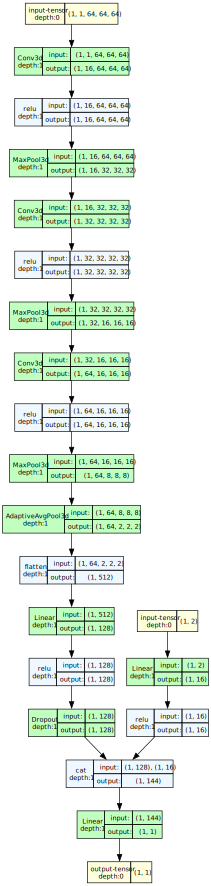

In [77]:
# Draw model graph
sample_image, sample_metadata, sample_label = dataset[0]

sample_image = sample_image.unsqueeze(0)
sample_metadata = sample_metadata.unsqueeze(0)

print(sample_image.shape)
print(sample_metadata.shape)

graph = draw_graph(model, input_data=(sample_image, sample_metadata), expand_nested=True, depth=4, graph_dir="TB", roll=False)
graph.visual_graph

# Hyperparameter tuning

In [ ]:
# Objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout', 0.2, 0.5)
    pooling_type = trial.suggest_categorical('pooling', ['max', 'avg'])
    filters = trial.suggest_categorical('filters', [(16, 32, 64), (32, 64, 128)])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])

    model = CNN3D(
        learning_rate=learning_rate,
        dropout=dropout_rate,
        filters=filters,
        kernel_size=kernel_size,
        pooling_type=pooling_type
    )

    data_module = CTScanDataModule(dataset, batch_size=4)  # batch_size is fixed because of memory reasons

    trainer = Trainer(
        max_epochs=100,
        accelerator="auto",
        devices=1,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=6)],
        logger=False,
        enable_checkpointing=False,
        enable_model_summary=False
    )

    trainer.fit(model, datamodule=data_module)

    val_loss = trainer.callback_metrics.get("val_loss")

    # Handle missing loss gracefully
    if val_loss is None:
        return float('inf')

    return val_loss.item()


# Create study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())



[I 2025-05-05 12:51:46,182] A new study created in memory with name: no-name-6caf70de-15df-49bf-9041-60438f87620d


## Run hyperparameter Tuning (Uncomment the following section and comment the hardcoded params)

In [ ]:
# Run study
# study.optimize(objective, n_trials=40)

In [79]:
# df = study.trials_dataframe()
# df.to_csv("optuna_trials_results.csv", index=False)
# print("✅ Optuna trials saved to 'optuna_trials_results.csv'")

In [ ]:
# best_params = study.best_trial.params
# print("Best hyperparameters found:", best_params)
# print("Best trial number:", study.best_trial.number)
# print("Best trial value:", study.best_trial.value)

In [ ]:
# I hardcoded the best parameters for reproducibility
# and to avoid running Optuna every time
# You can comment this and uncomment the lines above to run Optuna again
best_params = {
    "lr": 0.00015489692592807923,
    "dropout": 0.3541126312412523,
    "pooling": "max",
    "filters": (32, 64, 128),
    "kernel_size": 5
}

# Train best model

In [81]:
best_model = CNN3D(
    learning_rate=best_params['lr'],
    dropout=best_params['dropout'],
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    pooling_type=best_params['pooling']
)

data_module = CTScanDataModule(dataset, batch_size=4)

In [82]:
trainer = Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    logger=True,  # Enable logging now
    enable_checkpointing=True,
    default_root_dir="./optuna_best_model/"
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [83]:
%matplotlib inline
trainer.fit(best_model, datamodule=data_module)



   | Name        | Type                  | Params | Mode 
---------------------------------------------------------------
0  | accuracy    | BinaryAccuracy        | 0      | train
1  | precision   | BinaryPrecision       | 0      | train
2  | recall      | BinaryRecall          | 0      | train
3  | f1_score    | BinaryF1Score         | 0      | train
4  | specificity | BinarySpecificity     | 0      | train
5  | conf_matrix | BinaryConfusionMatrix | 0      | train
6  | conv1       | Conv3d                | 4.0 K  | train
7  | pool        | MaxPool3d             | 0      | train
8  | conv2       | Conv3d                | 256 K  | train
9  | conv3       | Conv3d                | 1.0 M  | train
10 | global_pool | AdaptiveAvgPool3d     | 0      | train
11 | fc1         | Linear                | 131 K  | train
12 | dropout     | Dropout               | 0      | train
13 | fc_metadata | Linear                | 48     | train
14 | fc2         | Linear                | 145    | train
15 | cr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

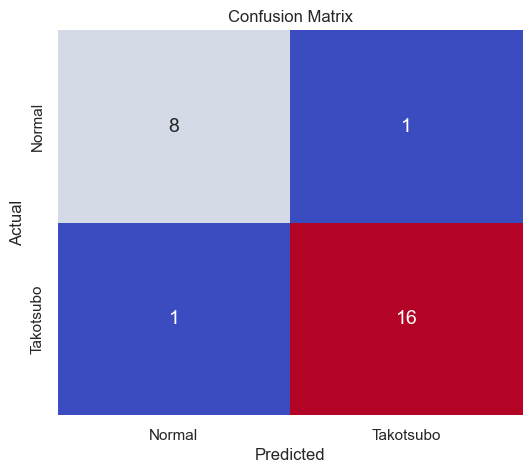

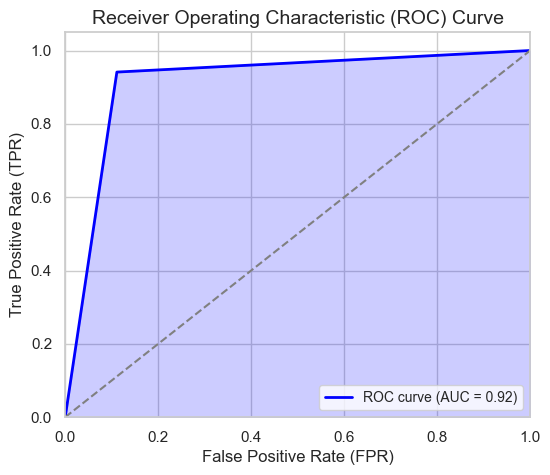

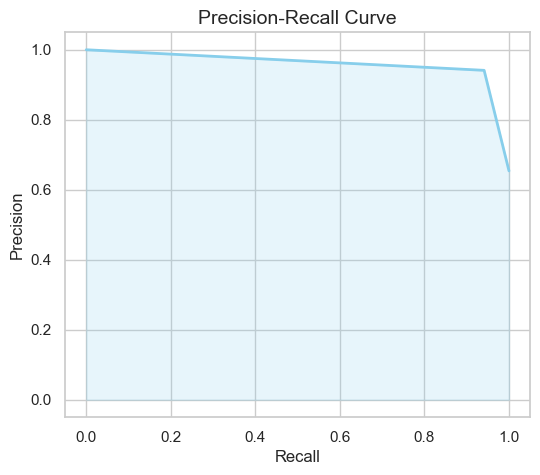

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9230769276618958     │
│          test_f1          │    0.9411764740943909     │
│         test_loss         │    0.10380621254444122    │
│      test_precision       │    0.9411764740943909     │
│        test_recall        │    0.9411764740943909     │
│     test_specificity      │    0.8888888955116272     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10380621254444122,
  'test_acc': 0.9230769276618958,
  'test_precision': 0.9411764740943909,
  'test_recall': 0.9411764740943909,
  'test_f1': 0.9411764740943909,
  'test_specificity': 0.8888888955116272}]

In [84]:
%matplotlib inline
trainer.test(best_model, datamodule=data_module)

# Plot training and validation graphs

In [87]:
# Get the latest lightning logs folder name
log_dir = "lightning_logs"
latest_version = max([int(d.split("_")[-1]) for d in os.listdir(log_dir) if "version_" in d])
metrics_path = os.path.join(log_dir, f"version_{latest_version}", "metrics.csv")

print(f"Loading metrics from: {metrics_path}")


Loading metrics from: lightning_logs/version_66/metrics.csv


    epoch  train_loss  val_loss  train_acc   val_acc
0       0    0.085466  1.232795        1.0  0.575758
1       1    0.622952  0.758773        0.0  0.500000
2       2    1.444557  0.909553        0.0  0.575758
3       3    0.750800  0.753563        0.0  0.530303
4       4    0.335819  0.929007        1.0  0.606061
5       5    1.092492  0.777588        0.0  0.507576
6       6    0.432887  0.744123        1.0  0.704545
7       7    0.269173  0.756651        1.0  0.712121
8       8    0.436040  0.726343        1.0  0.757576
9       9    0.037105  1.178006        1.0  0.750000
10     10    0.052160  0.988308        1.0  0.825758
11     11    0.003203  0.850089        1.0  0.909091
12     12    0.023359  1.375535        1.0  0.863636
13     13    0.274432  0.807383        1.0  0.909091
14     14    0.024003  0.955271        1.0  0.946970


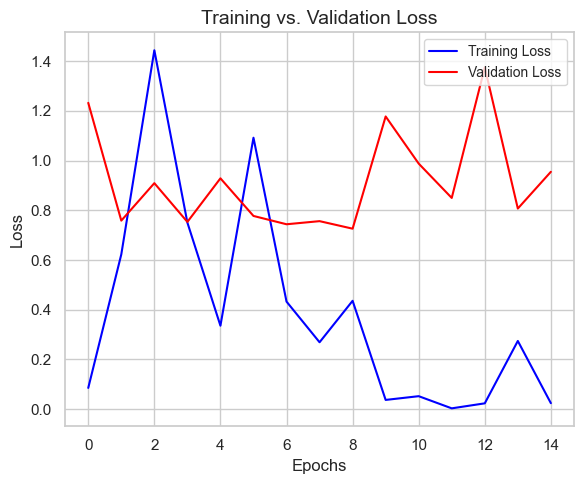

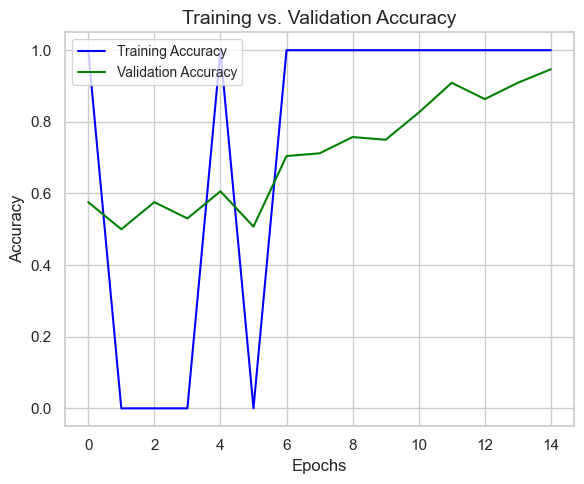

In [ ]:
def plot_training_curves(metrics_path="metrics.csv"):
    """Plots training & validation loss and accuracy curves from Lightning logs as separate images."""

    # Load CSV file
    df = pd.read_csv(metrics_path)

    # Remove rows with NaN epoch values
    df = df.dropna(subset=["epoch"])

    df["epoch"] = df["epoch"].astype(int)

    # Group by epoch (to avoid step-wise logging clutter)
    df = df.groupby("epoch").last().reset_index()

    # Drop NaN values (ensure complete logs)
    df = df.dropna(subset=["val_loss", "train_loss", "val_acc", "train_acc"])

    # Debugging: Print log
    print(df[["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]])

    if df.empty:
        print("⚠️ No valid data found for plotting! Check metrics logging.")
        return

    sns.set_theme(style="whitegrid")

    # Training vs Validation Loss
    plt.figure(figsize=(6, 5))
    sns.lineplot(x=df["epoch"], y=df["train_loss"], label="Training Loss", color="blue")
    sns.lineplot(x=df["epoch"], y=df["val_loss"], label="Validation Loss", color="red")
    plt.title("Training vs. Validation Loss", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.savefig("figures/loss_curve.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Training vs Validation Accuracy
    plt.figure(figsize=(6, 5))
    sns.lineplot(x=df["epoch"], y=df["train_acc"], label="Training Accuracy", color="blue")
    sns.lineplot(x=df["epoch"], y=df["val_acc"], label="Validation Accuracy", color="green")
    plt.title("Training vs. Validation Accuracy", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.savefig("figures/accuracy_curve.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_training_curves(metrics_path=metrics_path)

# Explainability: Grad-Cam

In [89]:
print(sample_image.shape)
show_scrollable_image(sample_image.squeeze().cpu().numpy())


torch.Size([1, 1, 64, 64, 64])


interactive(children=(IntSlider(value=31, description='slice_index', max=63), Output()), _dom_classes=('widget…

In [ ]:
def generate_gradcam(model, image_tensor, metadata_tensor):
    """
    Generates a Grad-CAM heatmap for a given model, image tensor, and metadata tensor.

    Args:
        model (torch.nn.Module): The trained model with Grad-CAM enabled.
        image_tensor (torch.Tensor): The input 3D image tensor (C x H x W x D).
        metadata_tensor (torch.Tensor): The metadata tensor (e.g., age, gender).

    Returns:
        numpy.ndarray: The Grad-CAM heatmap normalized to [0, 1].
    """
    model.eval()
    model.enable_gradcam = True

    # Ensure batch dimension
    image_tensor = image_tensor.unsqueeze(0) if image_tensor.ndim == 4 else image_tensor
    metadata_tensor = metadata_tensor.unsqueeze(0) if metadata_tensor.ndim == 1 else metadata_tensor
    metadata_tensor = metadata_tensor.view(1, -1)

    # Reset gradients and cached activations
    model.zero_grad()
    model.gradients = None
    model.activations = None

    # Forward + Backward
    output = model(image_tensor, metadata_tensor)
    output.backward()

    model.enable_gradcam = False

    activations = model.activations
    gradients = model.gradients

    if activations is None or gradients is None:
        raise RuntimeError("Missing Grad-CAM state. Make sure model.enable_gradcam = True before forward.")

    # Compute CAM
    weights = gradients.mean(dim=(2, 3, 4), keepdim=True)
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=image_tensor.shape[2:], mode="trilinear", align_corners=False)
    cam = cam.squeeze().detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-6)

    return cam

cam = generate_gradcam(model, sample_image, sample_metadata)


In [91]:
show_scrollable_image(cam, cmap="inferno")

interactive(children=(IntSlider(value=31, description='slice_index', max=63), Output()), _dom_classes=('widget…

In [93]:
show_scrollable_image_with_heatmap(sample_image.squeeze().cpu().numpy(), cam.squeeze(), alpha=0.6)

interactive(children=(IntSlider(value=31, description='slice_index', max=63), Output()), _dom_classes=('widget…

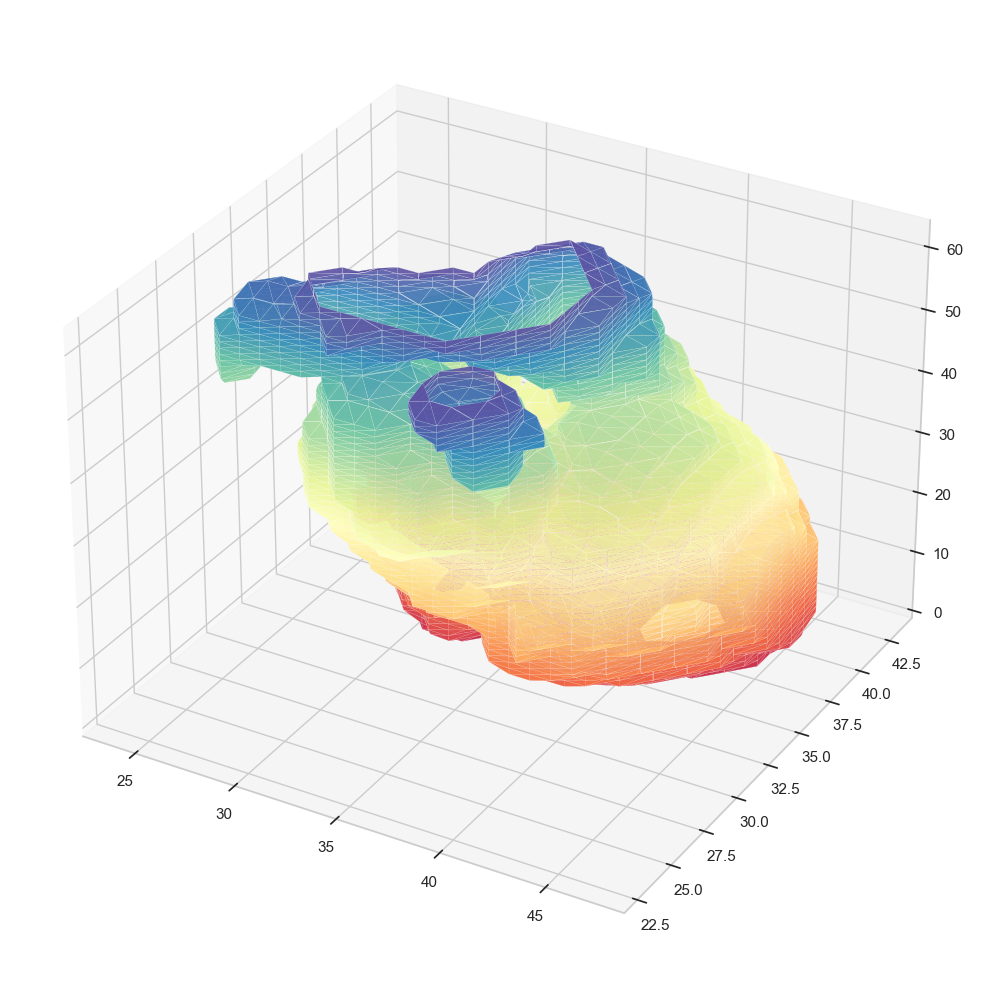

In [ ]:
plot_3d_segmentation(sample_image.squeeze().cpu().numpy())

# Visualise pipeline - For figures to use in my report

In [98]:
input_file_path = "../data/Inputs/takotsubo_cases/AD 12191953"
patient_id = "AD 12191953"

def resolve_dicom_folder_path(folder_path: str) -> str:
    """
    Given a patient folder path (e.g., ../data/Inputs/takotsubo_cases/LET_XXXXX), 
    returns the full path to the first subfolder inside the 'DICOM' directory.

    Args:
        folder_path (str): Path to the patient directory containing the DICOM folder.

    Returns:
        str: Full path to the actual DICOM subfolder.
    """
    dicom_root = os.path.join(folder_path, "DICOM")
    subfolders = sorted([
        f for f in os.listdir(dicom_root)
        if os.path.isdir(os.path.join(dicom_root, f))
    ])
    
    if not subfolders:
        raise FileNotFoundError(f"No subfolders found in {dicom_root}")
    
    return os.path.join(dicom_root, subfolders[0])

dicom_files_path = resolve_dicom_folder_path(input_file_path)
print(f"Resolved DICOM folder path: {dicom_files_path}")

Resolved DICOM folder path: ../data/Inputs/takotsubo_cases/AD 12191953/DICOM/MED RECONS 330 ms


In [99]:
def load_original_dicom(dicom_folder_path: str) -> MetaTensor:
    imageLoader = LoadImage(image_only=True)
    image = imageLoader(dicom_folder_path)
    return image

original_image = load_original_dicom(dicom_files_path)

print(f"Original image shape: {original_image.shape}")

original_image_metadata = torch.tensor([51, 1], dtype=torch.float32)  # [age, gender]


Original image shape: torch.Size([512, 512, 69])


In [100]:
show_scrollable_image(original_image.cpu().numpy())

interactive(children=(IntSlider(value=34, description='slice_index', max=68), Output()), _dom_classes=('widget…

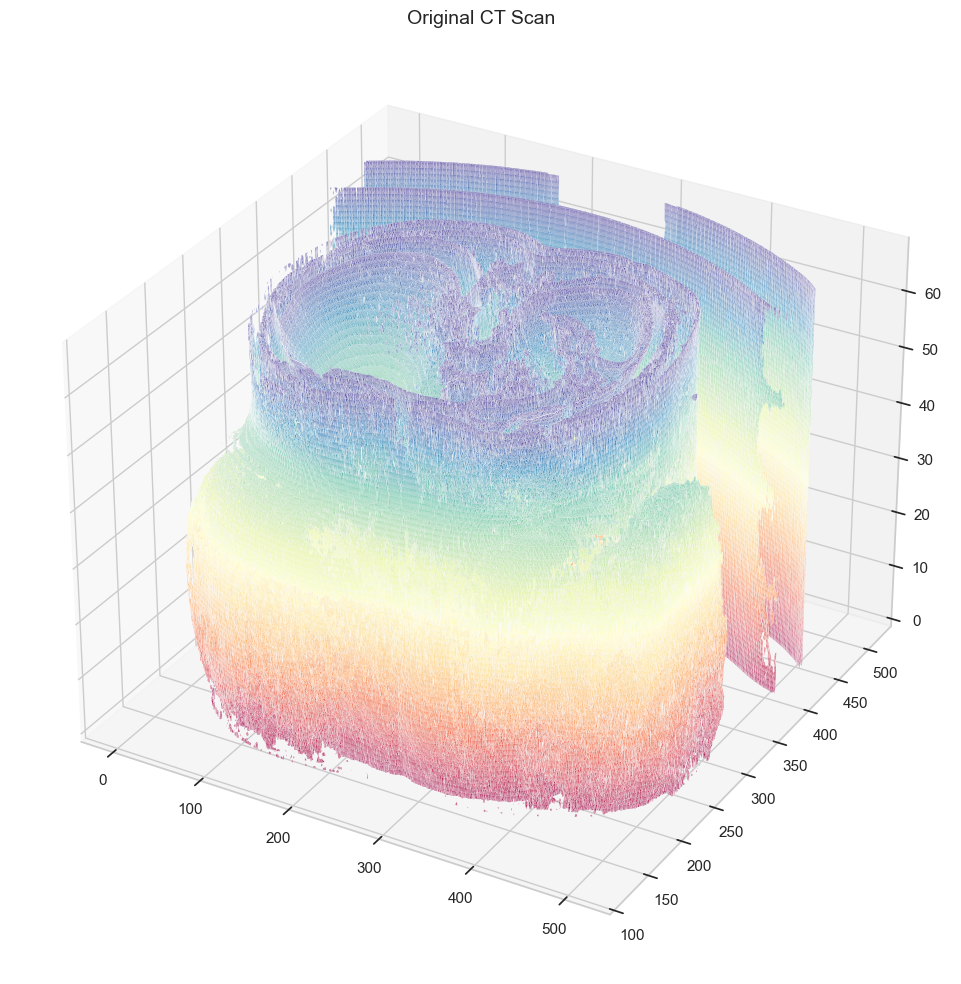

In [101]:
plot_3d_segmentation(original_image.cpu().numpy(), title="Original CT Scan")

In [102]:
def segment_heart_mask(dicom_folder: str, output_dir: str = None) -> MetaTensor:
    """Runs TotalSegmentator on the DICOM folder to extract the heart mask."""
    if output_dir is None:
        result = totalsegmentator(dicom_folder, skip_saving=True, roi_subset=["heart"], device="mps")
    else:
        result = totalsegmentator(dicom_folder, output_dir, roi_subset=["heart"], device="mps")
    mask = nifti1image_to_metatensor(result)
    return mask

segmented_heart_mask = segment_heart_mask(dicom_files_path)


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Converting dicom to nifti...
  found image with shape (512, 512, 69)
Resampling...
  Resampled in 0.54s
Predicting...


/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  Predicted in 6.93s
Resampling...
Converting dicom to nifti...
  found image with shape (512, 512, 69)
  cropping from (512, 512, 69) to (247, 197, 65)
Resampling...
  Resampled in 0.27s
Predicting part 1 of 1 ...


/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.16s/it]
/Users/awabakram/git/Takotsubo-Syndrome/myenv3/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  Predicted in 9.39s
Resampling...


In [103]:
print(segmented_heart_mask.shape)

torch.Size([512, 512, 69])


In [104]:
%matplotlib inline
show_scrollable_image(segmented_heart_mask.cpu().numpy())

interactive(children=(IntSlider(value=34, description='slice_index', max=68), Output()), _dom_classes=('widget…

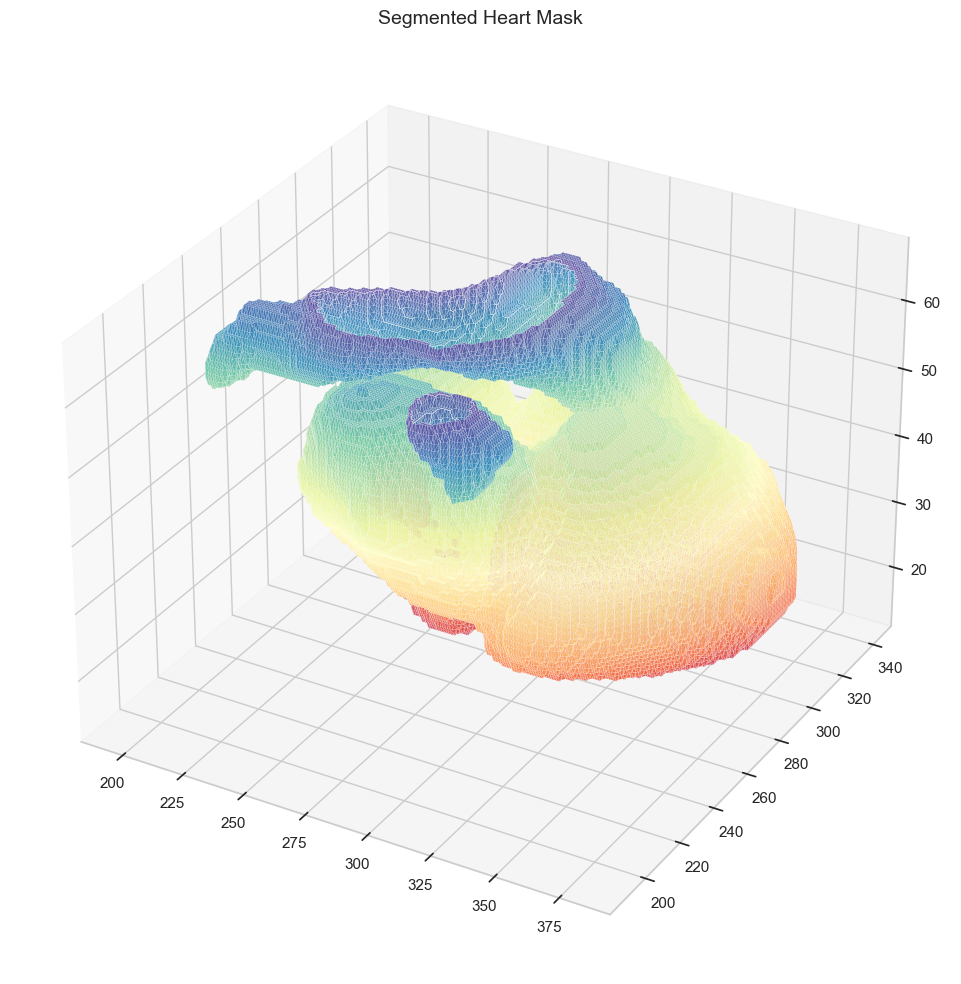

In [105]:
plot_3d_segmentation(segmented_heart_mask.cpu().numpy(), title="Segmented Heart Mask")

torch.Size([512, 512, 56])


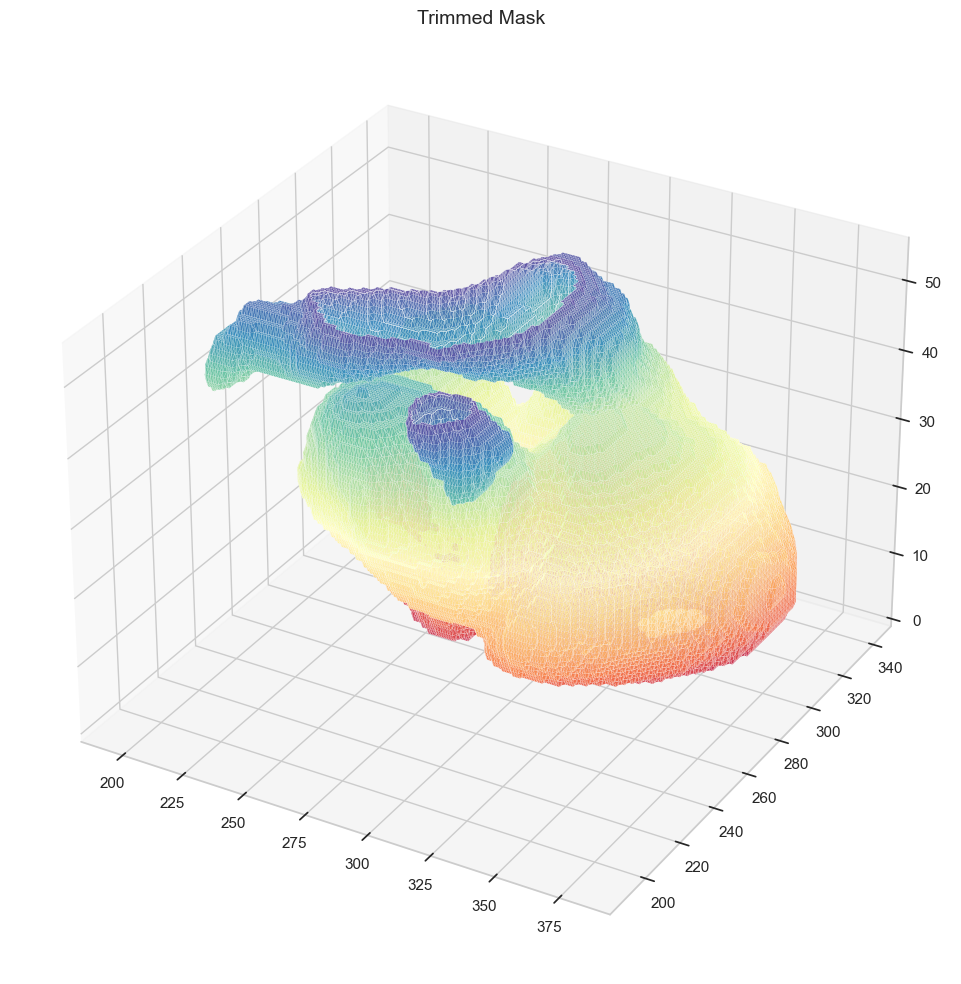

In [106]:
# STEP 3: Remove empty slices
z_indices = np.any(segmented_heart_mask > 0, axis=(0, 1))
heart_slices = np.where(z_indices)[0]

if len(heart_slices) == 0:
    raise ValueError("No heart region found in the mask.")

start_slice = heart_slices[0]
end_slice = heart_slices[-1] + 1


trimmed_mask = segmented_heart_mask[:, :, start_slice:end_slice]
print(trimmed_mask.shape)
plot_3d_segmentation(trimmed_mask.cpu().numpy(), title="Trimmed Mask")


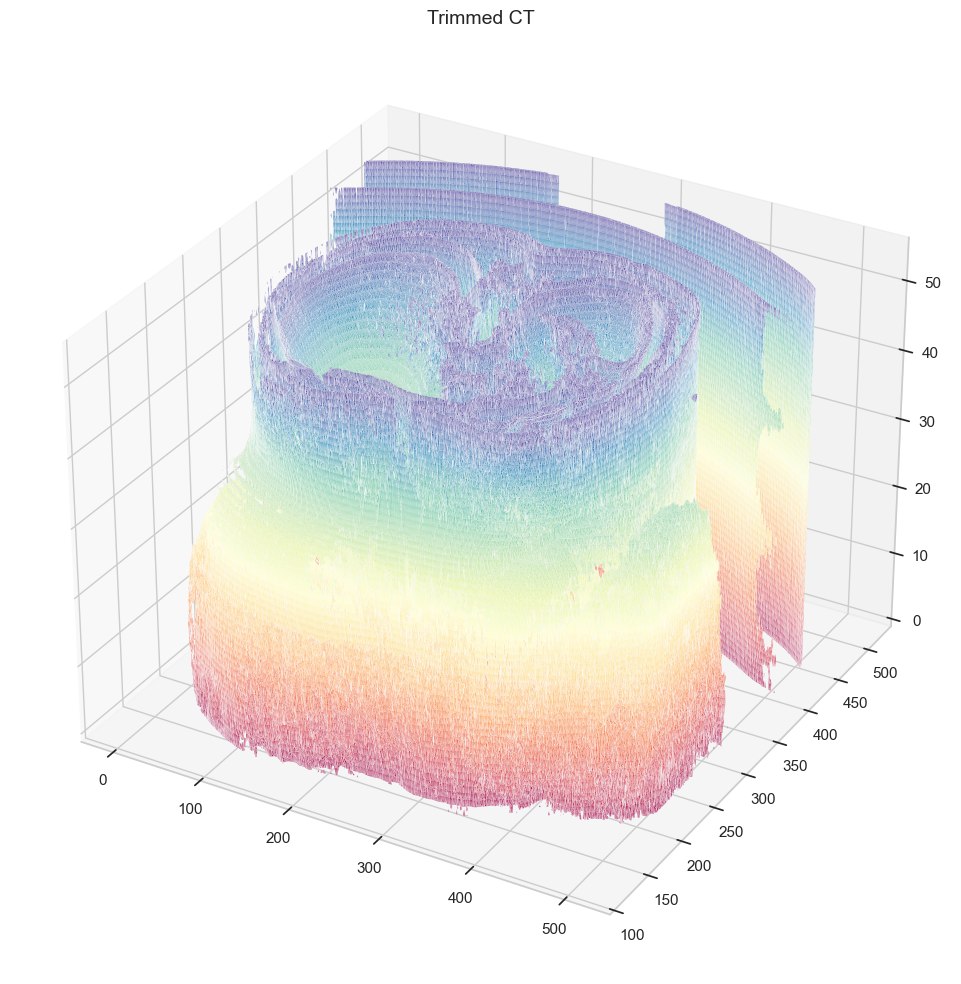

In [ ]:
# STEP 4: Trim original CT using mask bounds
trimmed_ct = original_image[:, :, start_slice:end_slice]
plot_3d_segmentation(trimmed_ct.cpu().numpy(), title="Trimmed CT")

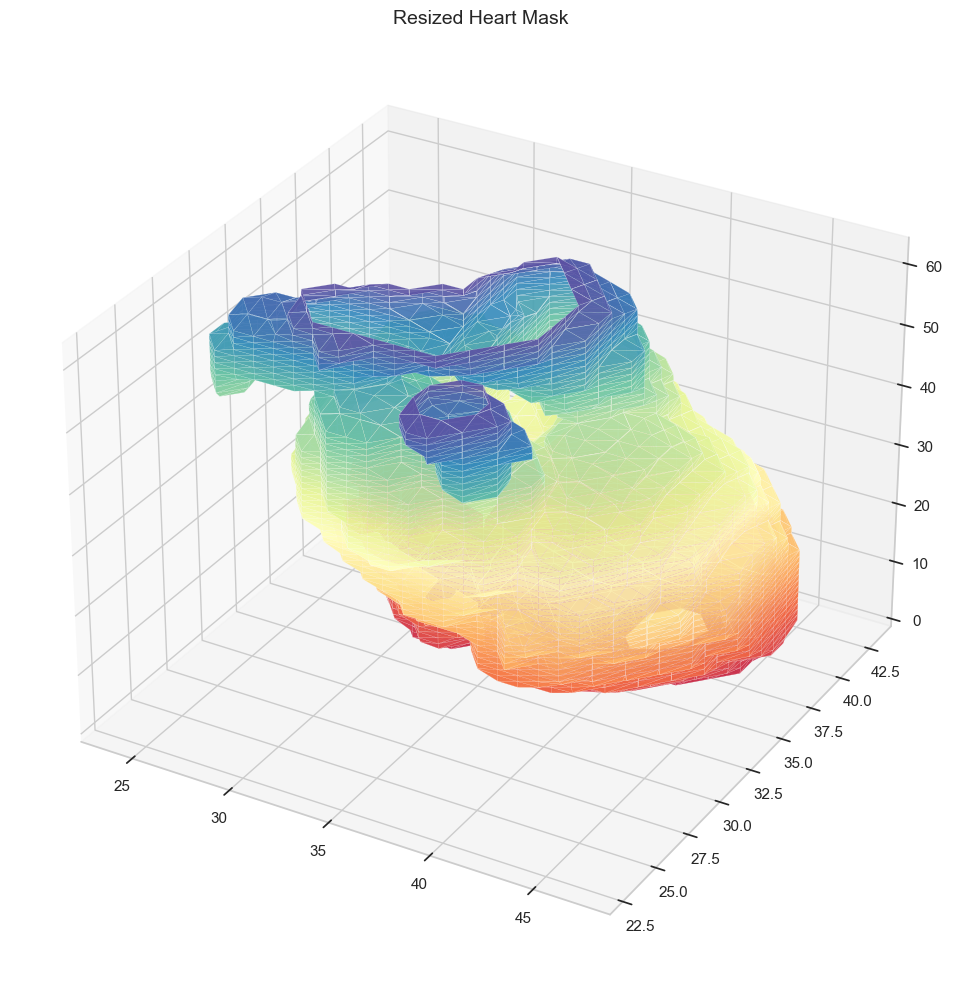

In [108]:
# STEP 5: Resize heart mask
target_shape = (64, 64, 64)

sliced_image = trimmed_mask.unsqueeze(0)  # Shape becomes (1, H, W, Z)
    
resizer = Resize(spatial_size=(target_shape[0],target_shape[1],target_shape[2]), mode="trilinear", align_corners=True)
resized_mask = resizer(sliced_image)

resized_mask = resized_mask.squeeze(0)
plot_3d_segmentation(resized_mask.cpu().numpy(), title="Resized Heart Mask")


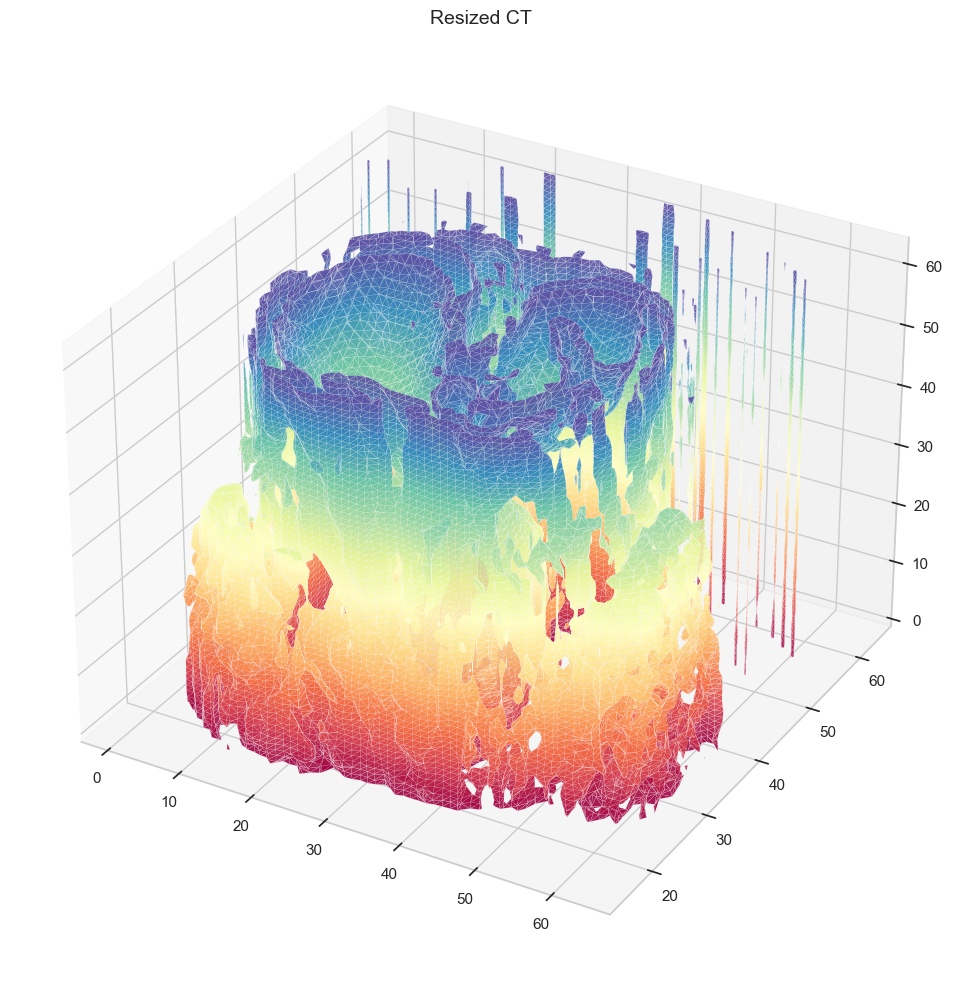

In [ ]:
# STEP 6: Resize original CT - useless (see image)
sliced_image = trimmed_ct.unsqueeze(0)  # Shape becomes (1, H, W, Z)
    
resizer = Resize(spatial_size=(target_shape[0],target_shape[1],target_shape[2]), mode="trilinear", align_corners=True)
resized_ct = resizer(sliced_image)

resized_ct = resized_ct.squeeze(0)
plot_3d_segmentation(resized_ct.cpu().numpy(), title="Resized CT")

In [110]:
print(resized_mask.shape)      # should be [D, H, W]
print(original_image_metadata.shape)   # should be [2]

image_tensor = torch.tensor(resized_mask[None, None]).float().to("cpu") 
metadata_tensor = torch.tensor(original_image_metadata[None]).float().to("cpu")  # shape: [1, num_features]
print(image_tensor.shape)  # should be [1, 1, D, H, W]
print(metadata_tensor.shape)  # should be [1, num_features]


torch.Size([64, 64, 64])
torch.Size([2])
torch.Size([1, 1, 64, 64, 64])
torch.Size([1, 2])


/var/folders/jm/k37qm_7n7dj5fp2rnwhd32y80000gn/T/ipykernel_77006/4253595370.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(resized_mask[None, None]).float().to("cpu")
/var/folders/jm/k37qm_7n7dj5fp2rnwhd32y80000gn/T/ipykernel_77006/4253595370.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metadata_tensor = torch.tensor(original_image_metadata[None]).float().to("cpu")  # shape: [1, num_features]


In [ ]:
gradcam = generate_gradcam(model, image_tensor, metadata_tensor)

In [ ]:
def plot_3d_views(segmentation_mask, threshold=0.5, title=""):
    """
    Plots a 3D segmentation mask from 4 different angles (360-degree view) and saves each view.

    Parameters:
        segmentation_mask (numpy.ndarray): The 3D segmentation mask to plot.
        threshold (float): Threshold for surface rendering of the segmentation mask.
        title (str): Title of the plot.
    """
    verts, faces, _, _ = measure.marching_cubes(segmentation_mask, level=threshold)

    angles = [0, 90, 180, 270]  # Different angles for the views

    for i, angle in enumerate(angles):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                               cmap='Spectral', lw=0.1, alpha=0.9)
        ax.view_init(elev=30, azim=angle)  # Set the view angle
        ax.set_title(f"{title} - View {i + 1}", fontsize=14)

        # Add color bar
        mappable = plt.cm.ScalarMappable(cmap='Spectral')
        mappable.set_array(segmentation_mask)
        cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
        cbar.set_label("Intensity", fontsize=10)

        # Save each view individually
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{title.replace(' ', '_').lower()}_view_{i + 1}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)  # Close the figure to clear it from memory

plot_3d_views(gradcam, title="Grad-CAM 360 View")

In [133]:
plot_3d_views(resized_mask.cpu().numpy(), title="Resized Heart Mask")

In [ ]:
def plot_3d_segmentation_with_heatmap(segmentation_mask, heatmap=None, threshold=0.5, title=""):
    """
    Plots a 3D segmentation mask with an optional heatmap overlay from multiple angles.

    Parameters:
        segmentation_mask (numpy.ndarray): The 3D segmentation mask to plot.
        heatmap (numpy.ndarray, optional): The 3D heatmap to overlay on the mask. Default is None.
        threshold (float): Threshold for surface rendering of the segmentation mask. Default is 0.5.
        title (str): Title of the plot. Default is an empty string.

    Returns:
        None: Saves the 3D plots from different angles as images in the 'figures' directory.
    """
    verts, faces, _, _ = measure.marching_cubes(segmentation_mask, level=threshold)

    angles = [0, 90, 180, 270]  # Different angles for the views
    os.makedirs("figures", exist_ok=True)  # Ensure the figures folder exists

    for i, angle in enumerate(angles):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                               cmap='grey', lw=0.1, alpha=0.9)

        if heatmap is not None:
            # Normalize the heatmap for better visualization
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
            heatmap_verts = verts.copy()
            heatmap_faces = faces.copy()
            ax.plot_trisurf(heatmap_verts[:, 0], heatmap_verts[:, 1], heatmap_faces, heatmap_verts[:, 2],
                            cmap='inferno', lw=0.1, alpha=0.5)

        ax.view_init(elev=30, azim=angle)  # Set the view angle
        ax.set_title(f"{title} - View {i + 1}", fontsize=14)

        # Add colorbar for the heatmap
        if heatmap is not None:
            mappable = plt.cm.ScalarMappable(cmap="inferno")
            mappable.set_array(heatmap)
            cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, pad=0.1)
            cbar.set_label("Heatmap Intensity", fontsize=10)

        # Save each view as a separate image
        plt.savefig(f"figures/{title.replace(' ', '_').lower()}_view_{i + 1}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)  # Close the figure to clear it from memory

plot_3d_segmentation_with_heatmap(resized_mask.cpu().numpy(), gradcam, title="grad-cam overlay")